In [3]:
# Importing pkgs, 
# please install relevant dependencies
from BondTrade.bondAnalytic import *

## Calculate PCA raw input date - synthetic bond yields series

In [4]:
par_cp_map = get_cmt_data()

2018-01-02 Done
2018-01-03 Done
2018-01-04 Done
2018-01-05 Done
2018-01-08 Done
2018-01-09 Done
2018-01-10 Done
2018-01-11 Done
2018-01-12 Done
2018-01-15 Done
2018-01-16 Done
2018-01-17 Done
2018-01-18 Done
2018-01-19 Done
2018-01-22 Done
2018-01-23 Done
2018-01-24 Done
2018-01-25 Done
2018-01-26 Done
2018-01-29 Done
2018-01-30 Done
2018-01-31 Done
2018-02-01 Done
2018-02-02 Done
2018-02-05 Done
2018-02-06 Done
2018-02-07 Done
2018-02-08 Done
2018-02-09 Done
2018-02-12 Done
2018-02-13 Done
2018-02-14 Done
2018-02-15 Done
2018-02-16 Done
2018-02-19 Done
2018-02-20 Done
2018-02-21 Done
2018-02-22 Done
2018-02-23 Done
2018-02-26 Done
2018-02-27 Done
2018-02-28 Done
2018-03-01 Done
2018-03-02 Done
2018-03-05 Done
2018-03-06 Done
2018-03-07 Done
2018-03-08 Done
2018-03-09 Done
2018-03-12 Done
2018-03-13 Done
2018-03-14 Done
2018-03-15 Done
2018-03-16 Done
2018-03-19 Done
2018-03-20 Done
2018-03-21 Done
2018-03-22 Done
2018-03-23 Done
2018-03-26 Done
2018-03-27 Done
2018-03-28 Done
2018-03-

## Visualize prefitted bond curves



In [5]:
mDate = date(2018,7,9) 

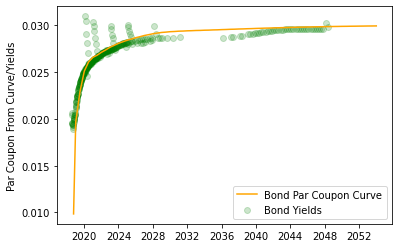

In [6]:
crv = curve_load(mDate)
curve_plot(mDate, crv)

## Calculate and visualize pca factors

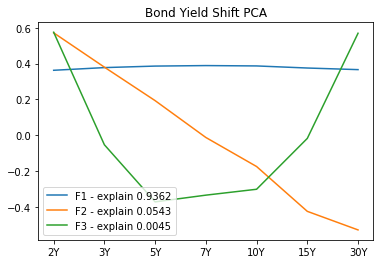

In [7]:
fac1, fac2 = generate_cmt_factors(mDate, par_cp_map, 60)

## Create hedging calculators

In [8]:
mkt = Market(mDate, {"US_BOND":crv}, mkt_price_map[mDate])
riskCalc = RiskCaclulator(mkt, ["2Y","3Y","5Y","7Y","10Y","15Y","30Y"])

### Risk remappers

In [9]:
pd.DataFrame(riskCalc.risk_remapper())

,0,1,2,3,4,5,6
0,0.987815,-0.026840,-0.016794,-0.012302,-0.008836,-0.005943,-0.003011
1,0.000000,1.014751,-0.025841,-0.018992,-0.013655,-0.009256,-0.004743
2,0.000000,0.000000,1.030652,-0.043136,-0.031062,-0.020967,-0.010779
3,0.000000,0.000000,0.000000,1.063518,-0.055982,-0.037884,-0.019444
4,0.000000,0.000000,0.000000,0.000000,1.099241,-0.090888,-0.046651
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.154312,-0.195054
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.272028


### Take use of the first 2 PCA factors. Contruct the factor neutural portfolio with biggest carries.

1. Belowing example only takes 3 bonds to vanish first 2 factors.
   
2. Simplied version with no repo and no contrains on shorts

In [10]:
all_res = []
all_res_m={}
valid_bonds = [bd[0] for bd in bond_map.items() if bd[1]._maturity>add_tenor(mDate,"18M") and bd[0] in mkt_price_map[mDate]]
len(valid_bonds)


234

In [11]:
for isin in valid_bonds:
    res = riskCalc.summarize_with_facotrs(bond_map[isin],"3M",{"F1":fac1,"F2":fac2})
    all_res.append((isin,res))
    all_res_m[isin] = res

In [12]:
all_res.sort(key = lambda x : x[1]["C+R/RF1"])
b_long = all_res[0]

second_res = all_res[1:]
best_third =-100
ratio = None
tgt = - np.matrix([[b_long[1]["Risk F1"],b_long[1]["Risk F2"]]]).T
b_sisin = None
bisin = None

for b_short in second_res:
    for bd in second_res:
        isin, bdinfo = bd
        if isin == b_short[0]:
            continue
        svm = np.matrix([[b_short[1]["Risk F1"],b_short[1]["Risk F2"]],
                  [bdinfo["Risk F1"],bdinfo["Risk F2"]]]).T

#         cr = np.matrix([[b_short[1]["Carry Roll Face Value"],bdinfo["Carry Roll Face Value"]]])
        try:
            res = inv(svm)*tgt
#             if abs(res[0,0])>1.5 or abs(res[1,0])>1.5:
#                 continue
#             crr = cr*res
#             total_cost = 1+res[0,0]+res[1,0]
            bd2 = all_res_m[b_short[0]]
            bd3 = all_res_m[isin]
            ret =(b_long[1]["Carry Roll Face Value"] +res[0,0]* bd2["Carry Roll Face Value"] +res[1,0]*bd3["Carry Roll Face Value"])
            initial = b_long[1]["Present Value"]+bd2["Present Value"]*max(res[0,0],0)+bd3["Present Value"]*max(res[1,0],0)

            if (ret/initial)>best_third: #and total_cost>1:
                ratio = res
                bisin = isin
                b_sisin = b_short[0]
                best_third = ret/initial
        except:
            pass
bd2 = all_res_m[b_sisin]
bd3 = all_res_m[bisin]
ret =(b_long[1]["Carry Roll Face Value"] +ratio[0,0]* bd2["Carry Roll Face Value"] +ratio[1,0]*bd3["Carry Roll Face Value"])
initial = b_long[1]["Present Value"]+bd2["Present Value"]*max(ratio[0,0],0)+bd3["Present Value"]*max(ratio[1,0],0)

print("weight: ",1,ratio[0,0],ratio[1,0])

print("expect annual return %: ",4*100*ret/initial)

df = pd.concat([pd.DataFrame([b_long[0],b_sisin, bisin],columns=["Isin"]),pd.DataFrame([b_long[1],bd2,bd3])],axis=1)
df


weight:  1 0.15349170390179412 0.0
expect annual return %:  3.4481358013782932


,Isin,Present Value,Clean Price,z-spread,Cash Today,DV01,Carry Roll Face Value,Carry,Roll,C+R/PV,Risk F1,Risk F2,C+R/DV01,C+R/RF1,C+R/RF2,Maturity
0,US9128283S79,99.214844,99.214844,0.005640,0,-0.013914,0.866177,0.765775,0.100402,0.008730,-0.013014,0.015289,-62.249989,-66.557166,56.652900,2020-01-31
1,US9128284J61,99.687500,99.687500,0.002298,0,-0.016180,0.788254,0.704259,0.083995,0.007907,-0.015133,0.017778,-48.718871,-52.089808,44.338407,2020-04-30
2,US912828X216,98.548534,98.199219,-0.000253,0,-0.015739,0.717621,0.630929,0.086691,0.007282,-0.014721,0.017294,-45.594624,-48.749389,41.495070,2020-04-15


### 该单个交易3M后回测结果

2018-10-09
profits:  1.1741970958904062 -0.38671899999999937 0.22378519178082001
total PnL:  1.1148389376492085
Annual Return %:  3.8940880509034836


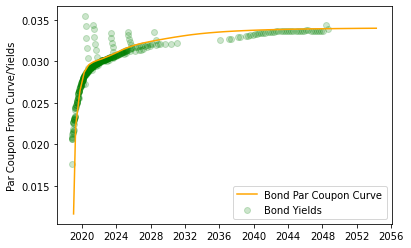

,Isin,Weight,3M PnL with 100
0,US9128283S79,1,0.0103
1,US9128284J61,0.1535,-0.0034
2,US912828X216,0.0,0.002


In [82]:
scenDate = modify_no_weekday(add_tenor(mDate,"3M"))
print(scenDate)
scenMkt = Market(scenDate,{},mkt_price_map[scenDate])


tik = b_long[0]
cash = riskCalc.cash_horizon(bond_map[tik],"3M")
pro1 = cash + BondPricer(bond_map[tik],scenMkt).dirty_price() - b_long[1]["Present Value"]


tik = b_sisin
cash = riskCalc.cash_horizon(bond_map[tik],"3M")
pro2 = cash + BondPricer(bond_map[tik],scenMkt).dirty_price() - bd2["Present Value"]

tik = bisin
cash = riskCalc.cash_horizon(bond_map[tik],"3M")
pro3 = cash + BondPricer(bond_map[tik],scenMkt).dirty_price() - bd3["Present Value"]

print("profits: ",pro1, pro2, pro3)
print("total PnL: ",pro1+ratio[0,0]*pro2+ratio[1,0]*pro3)
print("Annual Return %: ",400*(pro1+ratio[0,0]*pro2+ratio[1,0]*pro3)/initial)
scrv = curve_load(scenDate)
curve_plot(scenDate, scrv)
pd.DataFrame(np.array([[b_long[0],b_sisin, bisin],[1,round(ratio[0,0],4),round(ratio[1,0],4)],[round(pro1/initial,4), round(pro2/initial,4),round(pro3/initial,4)]]).T,columns=["Isin","Weight","3M PnL with 100"])